In [1]:
# Instala o SAM 2 diretamente do repositório oficial
!pip install git+https://github.com/facebookresearch/sam2.git

  Cloning https://github.com/facebookresearch/sam2.git to /tmp/pip-req-build-ja8_ux46
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/sam2.git /tmp/pip-req-build-ja8_ux46
  Resolved https://github.com/facebookresearch/sam2.git to commit 2b90b9f5ceec907a1c18123530e92e794ad901a4
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 8.6 MB/s eta 0:00:00
  Created wheel for SAM-2: filename=sam_2-1.0-cp312-cp312-linux_x86_64.whl size=505250 sha256=5d07e0a75dbf52fc86c6b9bf7036a6b190fe3a659ed9130ed5e9287ad30071aa
  Stored in directory: /tmp/pip-ephem-wheel-cache-lxe2n631/wheels/25/a3/8a/abd69dc6a6926b5e75c24810afac36c7b49b5c0f8a100147d6
  Created wheel for iopath: filename=iopath-0.1.10-py3-non

In [2]:
import os
import sys
import cv2
import numpy as np
import torch
from tqdm import tqdm
from google.colab import drive
!pip install hydra-core iopath -q

from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor


# 1. Montar o Drive
if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')

# 2. Configurar Caminhos
BASE_SAMSUNG = "/content/drive/MyDrive/SAMSUNG"
PATH_SAM2 = os.path.join(BASE_SAMSUNG, "sam2-main")

if PATH_SAM2 not in sys.path:
    sys.path.append(PATH_SAM2)

#  CAMINHOS DE ENTRADA
BASE_PBC = os.path.join(BASE_SAMSUNG, "PBC-YOLO-811")
IMG_ROOT = os.path.join(BASE_PBC, "images")
LBL_ROOT = os.path.join(BASE_PBC, "labels")

# CAMINHOS DE SAÍDA
OUT_BASE = os.path.join(BASE_SAMSUNG, "parametros")
OUT_IMG = os.path.join(OUT_BASE, "images")
OUT_MASK_SAM = os.path.join(OUT_BASE, "masks")

os.makedirs(OUT_IMG, exist_ok=True)
os.makedirs(OUT_MASK_SAM, exist_ok=True)

print(f" Diretórios configurados:")
print(f"  Entrada: {BASE_PBC}")
print(f"  Saída:   {OUT_BASE}")

# 3. Carregar Modelo
os.chdir(PATH_SAM2)
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f" Dispositivo: {device.upper()}")

predictor = SAM2ImagePredictor(build_sam2(
    "configs/sam2.1/sam2.1_hiera_l.yaml",
    "checkpoints/sam2.1_hiera_large.pt",
    device=device
))

predictor.model.mask_threshold = 0.0

# FUNÇÕES DE UTILIDADE

def pad_image_for_border_cells(img, pad_size=50):
    return cv2.copyMakeBorder(
        img,
        pad_size, pad_size, pad_size, pad_size,
        cv2.BORDER_REFLECT_101
    )

def is_near_border(cx, cy, bw, bh, img_width, img_height, threshold=1.5):
    margin_x = bw * threshold
    margin_y = bh * threshold
    return (cx < margin_x or cx > img_width - margin_x or
            cy < margin_y or cy > img_height - margin_y)

def choose_best_mask(masks, scores, bbox, point_coords, img_shape):
    if len(masks) == 0:
        return 0

    x1, y1, x2, y2 = bbox
    expected_area = max((x2 - x1) * (y2 - y1), 1)

    best_score = -1
    best_idx = 0

    for i, (mask, score) in enumerate(zip(masks, scores)):
        mask_area = mask.sum()
        if mask_area == 0:
            continue

        area_ratio = min(mask_area, expected_area) / max(mask_area, expected_area)

        cy, cx = point_coords[0]
        cy, cx = int(cy), int(cx)
        contains_center = False
        if 0 <= cy < mask.shape[0] and 0 <= cx < mask.shape[1]:
            contains_center = mask[cy, cx]

        rows = np.any(mask, axis=1)
        cols = np.any(mask, axis=0)
        if rows.sum() > 0 and cols.sum() > 0:
            rmin, rmax = np.where(rows)[0][[0, -1]]
            cmin, cmax = np.where(cols)[0][[0, -1]]
            mask_h = rmax - rmin + 1
            mask_w = cmax - cmin + 1
            aspect_ratio = min(mask_h, mask_w) / max(mask_h, mask_w, 1)
        else:
            aspect_ratio = 0

        combined_score = (
            score * 0.45 +
            area_ratio * 0.25 +
            (0.20 if contains_center else 0) +
            aspect_ratio * 0.10
        )

        if combined_score > best_score:
            best_score = combined_score
            best_idx = i

    return best_idx


def refine_mask(mask, class_id, min_area=10):
    class_mask = (mask == class_id).astype(np.uint8)
    if class_mask.sum() == 0:
        return mask

    kernel_close = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    class_mask = cv2.morphologyEx(class_mask, cv2.MORPH_CLOSE, kernel_close)

    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(class_mask, connectivity=8)
    for i in range(1, num_labels):
        if stats[i, cv2.CC_STAT_AREA] < min_area:
            class_mask[labels == i] = 0

    kernel_smooth = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2, 2))
    class_mask = cv2.morphologyEx(class_mask, cv2.MORPH_OPEN, kernel_smooth)

    mask[mask == class_id] = 0
    mask[class_mask > 0] = class_id

    return mask


def parse_yolo_label_advanced(txt_path, img_width, img_height, pad_size=0):
    cells = []
    if not os.path.exists(txt_path):
        return cells

    with open(txt_path, 'r') as f:
        for line in f:
            parts = line.split()
            if len(parts) >= 5:
                cls = int(parts[0]) + 1

                cx = float(parts[1]) * img_width
                cy = float(parts[2]) * img_height
                bw = float(parts[3]) * img_width
                bh = float(parts[4]) * img_height

                near_border = is_near_border(cx, cy, bw, bh, img_width, img_height)
                pad_factor = 0.20 if near_border else 0.10

                x1 = int(cx - (bw / 2) * (1 + pad_factor))
                y1 = int(cy - (bh / 2) * (1 + pad_factor))
                x2 = int(cx + (bw / 2) * (1 + pad_factor))
                y2 = int(cy + (bh / 2) * (1 + pad_factor))

                cx_adj = cx + pad_size
                cy_adj = cy + pad_size
                x1_adj = x1 + pad_size
                y1_adj = y1 + pad_size
                x2_adj = x2 + pad_size
                y2_adj = y2 + pad_size

                coords = [[int(cx_adj), int(cy_adj)]]
                labels = [1]

                if near_border:
                    offset = min(bw, bh) * 0.15
                    cross_points = [
                        (offset, 0), (-offset, 0),
                        (0, offset), (0, -offset)
                    ]
                    for dx, dy in cross_points:
                        px = int(cx_adj + dx)
                        py = int(cy_adj + dy)
                        if 0 <= px < img_width + 2*pad_size and 0 <= py < img_height + 2*pad_size:
                            coords.append([px, py])
                            labels.append(1)

                margin = 8
                neg_points = [
                    [max(0, int(cx_adj - bw/2 - margin)),
                     max(0, int(cy_adj - bh/2 - margin))],
                    [min(img_width + 2*pad_size - 1, int(cx_adj + bw/2 + margin)),
                     min(img_height + 2*pad_size - 1, int(cy_adj + bh/2 + margin))]
                ]
                for p in neg_points:
                    coords.append(p)
                    labels.append(0)

                cells.append({
                    'class': cls,
                    'bbox': np.array([x1_adj, y1_adj, x2_adj, y2_adj]),
                    'coords': np.array(coords),
                    'labels': np.array(labels),
                    'near_border': near_border,
                    'center': (int(cx_adj), int(cy_adj))
                })

    return cells


def create_sam2_mask_optimized(img, txt_path, pad_size=50):
    h, w = img.shape[:2]

    img_padded = pad_image_for_border_cells(img, pad_size=pad_size)
    cells = parse_yolo_label_advanced(txt_path, w, h, pad_size=pad_size)

    if not cells:
        return np.zeros((h, w), dtype=np.uint8)

    mask_padded = np.zeros((h + 2*pad_size, w + 2*pad_size), dtype=np.uint8)

    predictor.set_image(cv2.cvtColor(img_padded, cv2.COLOR_BGR2RGB))

    cells.sort(key=lambda c: (-c['near_border'],
                              -np.linalg.norm(np.array(c['center']) - np.array([w/2 + pad_size, h/2 + pad_size]))))

    for idx, cell in enumerate(cells):
        try:
            if idx > 0:
                existing_mask = (mask_padded > 0).astype(np.uint8)
                if existing_mask.sum() > 0:
                    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
                    dilated = cv2.dilate(existing_mask, kernel)
                    border_mask = dilated - existing_mask

                    border_coords = np.argwhere(border_mask > 0)
                    if len(border_coords) > 0:
                        num_neg_points = min(5, len(border_coords))
                        indices = np.random.choice(len(border_coords), num_neg_points, replace=False)
                        for i in indices:
                            y, x = border_coords[i]
                            cell['coords'] = np.vstack([cell['coords'], [x, y]])
                            cell['labels'] = np.append(cell['labels'], 0)

            masks, scores, _ = predictor.predict(
                point_coords=cell['coords'],
                point_labels=cell['labels'],
                box=cell['bbox'],
                multimask_output=True
            )

            best_idx = choose_best_mask(
                masks, scores, cell['bbox'],
                cell['coords'], mask_padded.shape
            )
            best_mask = masks[best_idx]

            mask_padded[best_mask.astype(bool) & (mask_padded == 0)] = cell['class']

        except Exception as e:
            print(f" Erro ao processar célula classe {cell['class']}: {e}")
            continue

    mask_final = mask_padded[pad_size:pad_size+h, pad_size:pad_size+w]

    unique_classes = np.unique(mask_final)
    for cls in unique_classes:
        if cls == 0:
            continue
        mask_final = refine_mask(mask_final, cls, min_area=10)

    return mask_final

# PROCESSAMENTO PRINCIPAL

TARGET_SIZE = (256, 256)
PAD_SIZE = 50

print(f" INICIANDO PROCESSAMENTO OTIMIZADO COM SAM2")
print(f" Padding: {PAD_SIZE}px")
print(f" Tamanho final: {TARGET_SIZE}")

for split in ['train', 'val', 'test']:
    img_split_path = os.path.join(IMG_ROOT, split)
    lbl_split_path = os.path.join(LBL_ROOT, split)

    if not os.path.exists(img_split_path):
        print(f" Pasta {split} não encontrada em {IMG_ROOT}. A saltar...")
        continue

    files = [f for f in os.listdir(img_split_path)
             if f.lower().endswith(('.jpg', '.png', '.jpeg'))]

    print(f"Split: {split.upper()} - {len(files)} imagens encontradas")

    for f in tqdm(files, desc=f"🔄 Processando {split}"):
        img_path = os.path.join(img_split_path, f)
        txt_path = os.path.join(lbl_split_path, os.path.splitext(f)[0] + ".txt")

        img = cv2.imread(img_path)
        if img is None:
            print(f" Não foi possível carregar: {f}")
            continue

        mask = create_sam2_mask_optimized(img, txt_path, pad_size=PAD_SIZE)

        img_res = cv2.resize(img, TARGET_SIZE, interpolation=cv2.INTER_LINEAR)
        mask_res = cv2.resize(mask, TARGET_SIZE, interpolation=cv2.INTER_NEAREST)

        save_name = f"{split}_{f}"
        cv2.imwrite(os.path.join(OUT_IMG, save_name), img_res)

        mask_filename = save_name.replace(".jpg", ".png").replace(".jpeg", ".png")
        cv2.imwrite(os.path.join(OUT_MASK_SAM, mask_filename), mask_res)


print(f" PROCESSAMENTO CONCLUÍDO COM SUCESSO!")
print(f" Imagens: {OUT_IMG}")
print(f" Máscaras: {OUT_MASK_SAM}")


# ESTATÍSTICAS FINAIS

print("\n Gerando estatísticas...")
total_masks = len([f for f in os.listdir(OUT_MASK_SAM) if f.endswith('.png')])
total_images = len([f for f in os.listdir(OUT_IMG)])

print(f" Total de imagens processadas: {total_images}")
print(f" Total de máscaras geradas: {total_masks}")

print(f"\n Verificando algumas máscaras...")
sample_masks = [f for f in os.listdir(OUT_MASK_SAM) if f.endswith('.png')][:10]

for mask_file in sample_masks:
    mask = cv2.imread(os.path.join(OUT_MASK_SAM, mask_file), cv2.IMREAD_GRAYSCALE)
    unique, counts = np.unique(mask, return_counts=True)
    print(f" {mask_file}: Classes detectadas: {unique.tolist()}")

print(f"\n TUDO PRONTO! Boa sorte com o treino! \n")

 Diretórios configurados:
  Entrada: /content/drive/MyDrive/SAMSUNG/PBC-YOLO-811
  Saída:   /content/drive/MyDrive/SAMSUNG/parametros
📱 Dispositivo: CUDA
 INICIANDO PROCESSAMENTO OTIMIZADO COM SAM2
 Padding: 50px
 Tamanho final: (256, 256)
Split: TRAIN - 13512 imagens encontradas


🔄 Processando train:   1%|          | 123/13512 [05:15<9:32:45,  2.57s/it]


KeyboardInterrupt: 

Encontrados 179 ficheiros em 'parametros/images'.


Validando: 100%|██████████| 100/100 [00:01<00:00, 54.07it/s]
/tmp/ipython-input-3508360172.py:94: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Status', y='Erro %', palette='magma')


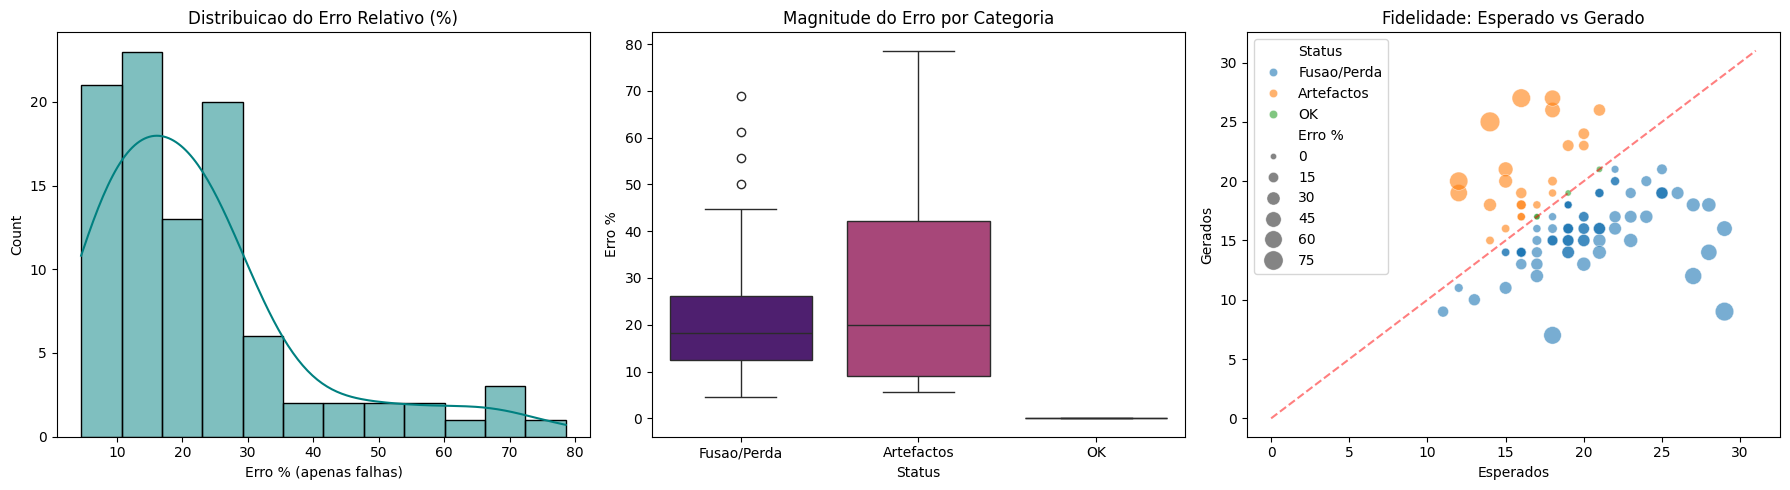


Media de Erro Relativo: 21.58%

Top 5 maiores erros:


,Ficheiro,Split,Esperados,Gerados,Erro %,Status
41,train_SNE_338242.jpg,train,14,25,78.57,Artefactos
67,train_SNE_389572.jpg,train,29,9,68.97,Fusao/Perda
64,train_SNE_330213.jpg,train,16,27,68.75,Artefactos
75,train_SNE_440901.jpg,train,12,20,66.67,Artefactos
74,train_SNE_352977.jpg,train,18,7,61.11,Fusao/Perda


In [ ]:
import os
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from skimage import measure
from tqdm import tqdm

BASE_SAMSUNG = "/content/drive/MyDrive/SAMSUNG"

BASE_PBC  = os.path.join(BASE_SAMSUNG, "PBC-YOLO-811")
IMG_ROOT  = os.path.join(BASE_PBC, "images")
LBL_ROOT  = os.path.join(BASE_PBC, "labels")

OUT_IMG_SAM  = os.path.join(BASE_SAMSUNG, "parametros/images")
OUT_MASK_SAM = os.path.join(BASE_SAMSUNG, "parametros/masks")

# 2. FUNCAO DE VALIDACAO

def validar_dataset_final(img_gen_root, mask_gen_root, lbl_orig_root, max_imgs=100):
    report_data = []

    if not os.path.exists(img_gen_root):
        print(f"Pasta nao encontrada: {img_gen_root}")
        return pd.DataFrame()

    gerados_files = [
        f for f in os.listdir(img_gen_root)
        if f.lower().endswith(('.jpg', '.png'))
    ]
    print(f"Encontrados {len(gerados_files)} ficheiros em 'parametros/images'.")

    for f in tqdm(gerados_files[:max_imgs], desc="Validando"):
        parts = f.split('_', 1)
        if len(parts) < 2:
            continue

        split     = parts[0]
        base_name = os.path.splitext(parts[1])[0]

        # Contagem de celulas esperadas (labels YOLO originais)
        txt_path = os.path.join(lbl_orig_root, split, base_name + ".txt")
        esperados = 0

        if os.path.exists(txt_path):
            with open(txt_path, 'r') as file:
                esperados = len([line for line in file if line.strip()])
        else:
            txt_path_alt = os.path.join(lbl_orig_root, split, os.path.splitext(f)[0] + ".txt")
            if os.path.exists(txt_path_alt):
                with open(txt_path_alt, 'r') as file:
                    esperados = len([line for line in file if line.strip()])

        # Contagem de celulas geradas (mascara SAM)
        mask_name = os.path.splitext(f)[0] + ".png"
        mask_path = os.path.join(mask_gen_root, mask_name)
        gerados   = 0

        if os.path.exists(mask_path):
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            if mask is not None:
                gerados = measure.label(mask > 0).max()

        diff     = gerados - esperados
        erro_pct = (abs(diff) / esperados * 100) if esperados > 0 else (100 if gerados > 0 else 0)

        report_data.append({
            'Ficheiro' : f,
            'Split'    : split,
            'Esperados': esperados,
            'Gerados'  : gerados,
            'Erro %'   : round(erro_pct, 2),
            'Status'   : "OK" if diff == 0 else ("Artefactos" if diff > 0 else "Fusao/Perda")
        })

    df = pd.DataFrame(report_data)

    if not df.empty:
        plt.figure(figsize=(18, 5))

        plt.subplot(1, 3, 1)
        sns.histplot(df[df['Erro %'] > 0]['Erro %'], kde=True, color='teal')
        plt.title('Distribuicao do Erro Relativo (%)')
        plt.xlabel('Erro % (apenas falhas)')

        plt.subplot(1, 3, 2)
        sns.boxplot(data=df, x='Status', y='Erro %', palette='magma')
        plt.title('Magnitude do Erro por Categoria')

        plt.subplot(1, 3, 3)
        sns.scatterplot(
            data=df, x='Esperados', y='Gerados',
            hue='Status', size='Erro %',
            sizes=(20, 200), alpha=0.6
        )
        max_val = max(df['Esperados'].max(), df['Gerados'].max()) + 2
        plt.plot([0, max_val], [0, max_val], 'r--', alpha=0.5)
        plt.title('Fidelidade: Esperado vs Gerado')

        plt.tight_layout()
        plt.show()

        print(f"\nMedia de Erro Relativo: {df['Erro %'].mean():.2f}%")
        print("\nTop 5 maiores erros:")
        display(df.sort_values(by='Erro %', ascending=False).head(5))

    else:
        print("Nenhum dado processado para gerar graficos.")

    return df


df_erro = validar_dataset_final(OUT_IMG_SAM, OUT_MASK_SAM, LBL_ROOT, max_imgs=100)

Validando train:   1%|          | 100/13512 [00:01<02:44, 81.52it/s]


Processadas 100 imagens.
Media de Erro Relativo: 21.58%


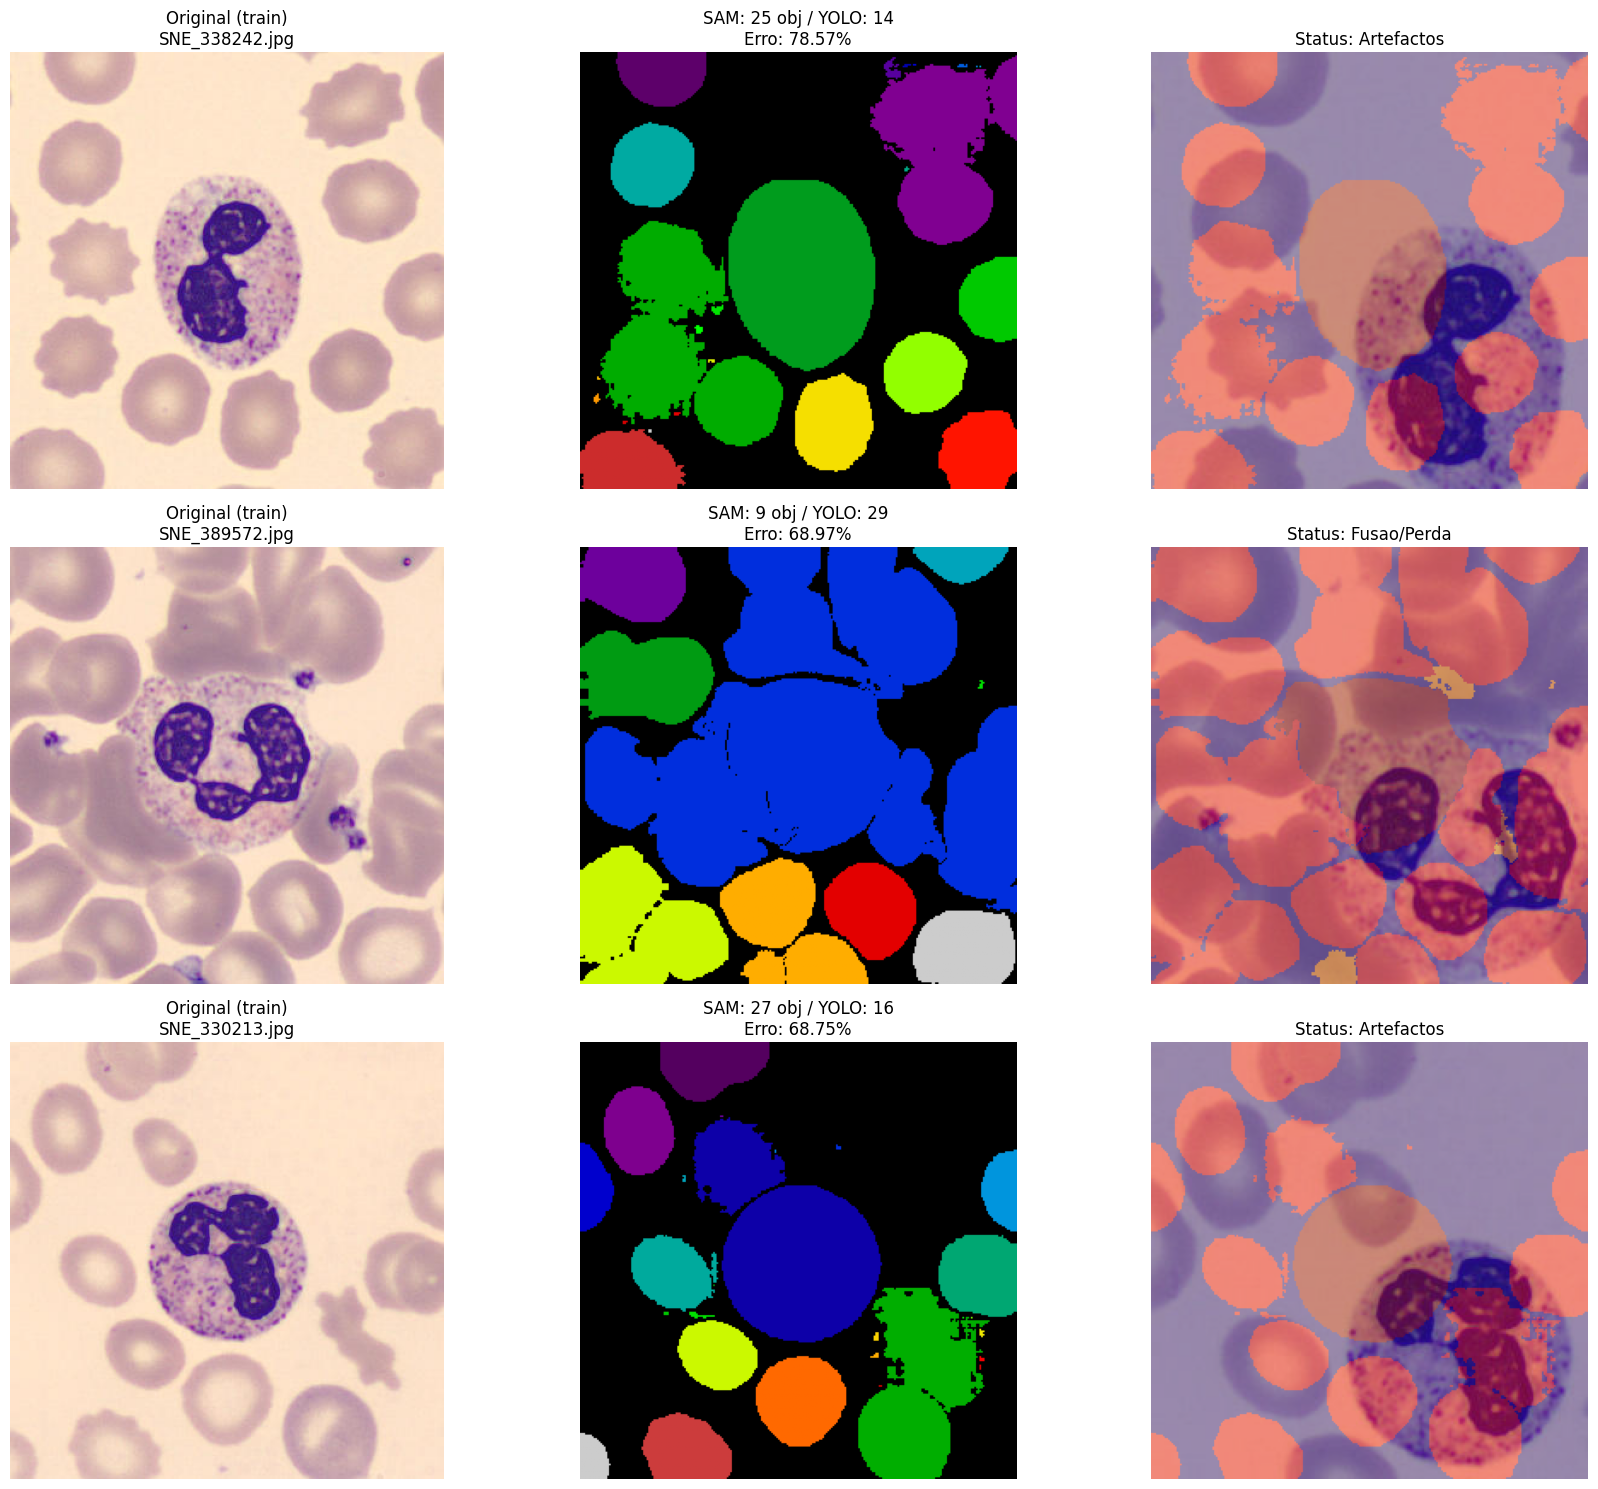

In [ ]:
import os
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from skimage import measure
from tqdm import tqdm


BASE_SAMSUNG = "/content/drive/MyDrive/SAMSUNG"

BASE_PBC  = os.path.join(BASE_SAMSUNG, "PBC-YOLO-811")
IMG_ROOT  = os.path.join(BASE_PBC, "images")
LBL_ROOT  = os.path.join(BASE_PBC, "labels")

OUT_BASE   = os.path.join(BASE_SAMSUNG, "parametros")
OUT_IMG_SAM  = os.path.join(OUT_BASE, "images")
OUT_MASK_SAM = os.path.join(OUT_BASE, "masks")


# 2. FUNCAO DE VALIDACAO


def validar_dataset_completo(img_root, lbl_root, mask_out_root, max_imgs=100):
    report_data = []
    total       = 0

    for split in ['train', 'val', 'test']:
        if total >= max_imgs:
            break

        img_p = os.path.join(img_root, split)
        lbl_p = os.path.join(lbl_root, split)

        if not os.path.exists(img_p):
            continue

        files = [
            f for f in os.listdir(img_p)
            if f.lower().endswith(('.jpg', '.png'))
        ]

        for f in tqdm(files, desc=f"Validando {split}"):
            if total >= max_imgs:
                break

            # Contagem de celulas esperadas (label YOLO original)
            txt_path  = os.path.join(lbl_p, os.path.splitext(f)[0] + ".txt")
            esperados = 0
            if os.path.exists(txt_path):
                with open(txt_path, 'r') as file:
                    esperados = len([l for l in file if l.strip()])

            # Contagem de celulas geradas (mascara SAM)
            mask_name = f"{split}_{os.path.splitext(f)[0]}.png"
            m_path    = os.path.join(mask_out_root, mask_name)
            gerados   = 0

            if os.path.exists(m_path):
                mask = cv2.imread(m_path, cv2.IMREAD_GRAYSCALE)
                if mask is not None:
                    gerados = measure.label(mask > 0).max()

            diff     = gerados - esperados
            erro_pct = (abs(diff) / esperados * 100) if esperados > 0 else (100 if gerados > 0 else 0)

            report_data.append({
                'Ficheiro' : f,
                'Split'    : split,
                'Esperados': esperados,
                'Gerados'  : gerados,
                'Erro %'   : round(erro_pct, 2),
                'Status'   : "OK" if diff == 0 else ("Artefactos" if diff > 0 else "Fusao/Perda")
            })
            total += 1

    return pd.DataFrame(report_data)

# 3. VISUALIZACAO DOS ERROS CRITICOS


def visualizar_erros_criticos(df, img_root, mask_root):
    if df.empty:
        print("DataFrame vazio. Verifique os caminhos.")
        return

    piores = df.sort_values(by='Erro %', ascending=False).head(3)
    fig, axes = plt.subplots(3, 3, figsize=(18, 15))

    for i, (idx, row) in enumerate(piores.iterrows()):
        split = row['Split']
        f     = row['Ficheiro']

        img_path  = os.path.join(img_root, split, f)
        mask_path = os.path.join(mask_root, f"{split}_{os.path.splitext(f)[0]}.png")

        img  = cv2.imread(img_path)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        if img is not None and mask is not None:
            img_rgb      = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            labeled_mask = measure.label(mask > 0)

            axes[i, 0].imshow(img_rgb)
            axes[i, 0].set_title(f"Original ({split})\n{f}")

            axes[i, 1].imshow(labeled_mask, cmap='nipy_spectral')
            axes[i, 1].set_title(
                f"SAM: {row['Gerados']} obj / YOLO: {row['Esperados']}\n"
                f"Erro: {row['Erro %']}%"
            )

            axes[i, 2].imshow(img_rgb)
            axes[i, 2].imshow(mask, alpha=0.4, cmap='jet')
            axes[i, 2].set_title(f"Status: {row['Status']}")

        for ax in axes[i]:
            ax.axis('off')

    plt.tight_layout()
    plt.show()

# 4. EXECUCAO

df_final = validar_dataset_completo(IMG_ROOT, LBL_ROOT, OUT_MASK_SAM, max_imgs=100)

if not df_final.empty:
    print(f"Processadas {len(df_final)} imagens.")
    print(f"Media de Erro Relativo: {df_final['Erro %'].mean():.2f}%")
    visualizar_erros_criticos(df_final, IMG_ROOT, OUT_MASK_SAM)